# Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
import warnings
from PIL import Image

#Torch

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torchvision.io import read_image
#Torch model
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
import time

import gdown
import zipfile
from tqdm import tqdm

In [3]:
warnings.filterwarnings("ignore")

In [4]:
!nvidia-smi

Wed May  1 13:17:34 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 35%   40C    P8    10W /  75W |   2695MiB /  4096MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

# Data Processing



### Upload data to colab

In [7]:
if not os.path.exists("wb_recognition_dataset.zip"):
    !gdown --id 1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh
else:
    print("File already exists, skipping download.")

File already exists, skipping download.


In [8]:
if not os.path.exists("wb_recognition_dataset"):
    with zipfile.ZipFile("wb_recognition_dataset.zip", "r") as zip_ref:
        zip_ref.extractall("wb_recognition_dataset")

In [9]:
local_dir = 'wb_recognition_dataset'

In [13]:
dataset_dir = f'{local_dir}'
trainset_dir = f'{dataset_dir}/train'
testset_dir = f'{dataset_dir}/val'
testset_img = f'{testset_dir}/images'
annotations_dir = f'{testset_dir}/labels.csv'

In [14]:
print('Number of classes in the train dataset:', len(os.listdir(trainset_dir)))
print('Number of images in the valid dataset:', len(os.listdir(testset_img)))

Number of classes in the train dataset: 2130
Number of images in the valid dataset: 1392


### Data Pre-processing

In [15]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),  # Convert image to tensor
])

In [41]:
# get all the full image dirs in each folder
data = [
    (os.path.join(trainset_dir, c, f), int(c))
    for c in os.listdir(trainset_dir)
    for f in os.listdir(os.path.join(trainset_dir, c))
]

In [17]:
classes = [int(c) for c in os.listdir(trainset_dir)]
classes.sort()
num_classes = classes[-1] # assume that the largest number is the number of classes
classes = set(range(num_classes))
print(len(classes))

2138


In [18]:
def encoding(df, classes=classes):
    # one hot encoding
    for i in tqdm(classes):
        df[str(i)] = (df['label'] == i).astype(int)
    df.drop('label', axis=1, inplace=True)
    return df

In [19]:

main_df = pd.DataFrame(data, columns = ['image', 'label'])
main_df

,image,label
0,wb_recognition_dataset/train\0\11_0.png,0
1,wb_recognition_dataset/train\0\12_0.png,0
2,wb_recognition_dataset/train\0\16_0.png,0
3,wb_recognition_dataset/train\0\17_0.png,0
4,wb_recognition_dataset/train\0\19_0.png,0
...,...,...
56808,wb_recognition_dataset/train\999\16_999.png,999
56809,wb_recognition_dataset/train\999\17_999.png,999
56810,wb_recognition_dataset/train\999\35_999.png,999
56811,wb_recognition_dataset/train\999\46_999.png,999


In [20]:
main_df = pd.DataFrame(data, columns = ['image', 'label'])
main_df = encoding(main_df)
main_df

  0%|          | 0/2138 [00:00<?, ?it/s]

100%|██████████| 2138/2138 [00:01<00:00, 1486.32it/s]


,image,0,1,2,3,4,5,6,7,8,...,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137
0,wb_recognition_dataset/train\0\11_0.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,wb_recognition_dataset/train\0\12_0.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,wb_recognition_dataset/train\0\16_0.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,wb_recognition_dataset/train\0\17_0.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,wb_recognition_dataset/train\0\19_0.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56808,wb_recognition_dataset/train\999\16_999.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56809,wb_recognition_dataset/train\999\17_999.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56810,wb_recognition_dataset/train\999\35_999.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56811,wb_recognition_dataset/train\999\46_999.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# check if all rows only have at maximum of 1 class
assert main_df.iloc[:, 1:].sum(axis=1).max() == 1

In [22]:
# find the label of an image
for c in main_df.columns[1:]:
    if main_df[c].iloc[1] == 1: # change the index to find the label of another image, just for testing
        print(c)

0


In [23]:
# train_df = main_df.sample(frac=ratio, random_state=42)
# valid_df = main_df.drop(train_df.index)

# print(f'All Data: {main_df.shape}, Train Data: {train_df.shape}, Valid Data: {valid_df.shape}')

In [24]:
valid_label = pd.read_csv(annotations_dir)
valid_label.iloc[0][1]

10

In [25]:
valid_data = [
    (os.path.join(testset_img, str(valid_label.iloc[i, 0])+ ".jpg"), int(valid_label.iloc[i, 1]))
    for i in range(valid_label.shape[0])
]

In [26]:
val_df = pd.DataFrame(valid_data, columns = ['image', 'label'])
val_df = encoding(val_df)
val_df

100%|██████████| 2138/2138 [00:01<00:00, 1886.14it/s]


,image,0,1,2,3,4,5,6,7,8,...,2128,2129,2130,2131,2132,2133,2134,2135,2136,2137
0,wb_recognition_dataset/val/images\0.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,wb_recognition_dataset/val/images\1.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,wb_recognition_dataset/val/images\2.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,wb_recognition_dataset/val/images\3.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,wb_recognition_dataset/val/images\4.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,wb_recognition_dataset/val/images\1387.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1388,wb_recognition_dataset/val/images\1388.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389,wb_recognition_dataset/val/images\1389.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1390,wb_recognition_dataset/val/images\1390.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
def process_img(img_path: str, width=64, height=64):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # result = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    result = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 17)
    result = cv2.resize(result, (width, height))
    result = Image.fromarray(result).convert('RGB')

    return result

In [28]:
class CNV_Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = df.iloc[:, 1:].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        img = process_img(img_path=img_path)
        img_tensor = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img_tensor, label

In [29]:
trainset = CNV_Dataset(main_df, transform=transform)
validset = CNV_Dataset(val_df, transform=transform)

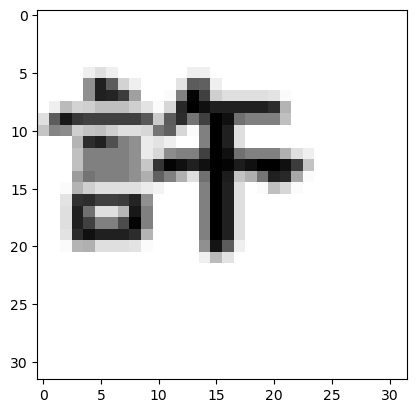

tensor([1., 0., 0.,  ..., 0., 0., 0.])


In [30]:
# see a sample image, plot it
img, label = trainset[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(label)

### DataLoader


In [31]:
batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)

# Model

### Model Architecture

#### Alexnet (Custom)
Input:
- 3 x 227 x 227

Output:

- 1000 (Base) -> 2130 (Adjusted)


In [32]:
class AlexNet(nn.Module):
    def __init__(self, out_dim):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, out_dim))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#### Custom Model

In [33]:
# MNIST (1, 28, 28)
class CustomBuiltModel(nn.Module):
    def __init__(self, out_dim=10):
        super(CustomBuiltModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)

        x = torch.randn(3, 32, 32).view(-1, 3, 32, 32)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, out_dim)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self, out_dim):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, out_dim)

    def forward(self, x): # x dim: 3, 32, 32
        x = F.relu(self.conv1(x)) # dim: 16, 32, 32
        x = self.pool(x) # dim: 16, 16, 16
        x = F.relu(self.conv2(x)) # dim: 32, 16, 16
        x = self.pool(x) # dim: 32, 8, 8
        x = x.view(-1, 32 * 8 * 8) # dim: 32 * 8 * 8
        x = F.relu(self.fc1(x)) # dim: 128
        x = self.fc2(x) # dim: out_dim
        return x

### Initiate Model

Note: Change the input data transform fuction accordingly to the chosen model


In [35]:
outdim = num_classes

In [36]:
model = SimpleCNN(outdim).to(device)
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2138, bias=True)
)

# Traning



### Parameter

In [37]:
leaning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=leaning_rate)

### Traning Loop

In [38]:
def train(epoch):
    model.train()
    for x, y in tqdm(train_loader):
        x = x.to(device)
        # print(x.shape)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, torch.argmax(y, 1))
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

In [39]:
def valid():
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss += criterion(output, y).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.argmax(dim=1, keepdim=True)).sum().item()
    loss /= len(val_loader.dataset)
    accuracy =correct / len(val_loader.dataset)
    return loss, accuracy

In [40]:
epochs = 10
for epoch in range(epochs):
    train(epoch)
    print(valid())

100%|██████████| 888/888 [00:32<00:00, 27.75it/s]


Epoch: 0, Loss: 6.185853958129883


100%|██████████| 22/22 [00:03<00:00,  6.00it/s]


(0.07287502562862704, 0.3017241379310345)


100%|██████████| 888/888 [00:28<00:00, 31.22it/s]


Epoch: 1, Loss: 4.019102573394775


100%|██████████| 22/22 [00:00<00:00, 31.19it/s]


(0.04859547342719703, 0.47485632183908044)


100%|██████████| 888/888 [00:27<00:00, 31.82it/s]


Epoch: 2, Loss: 2.9833407402038574


100%|██████████| 22/22 [00:00<00:00, 32.91it/s]


(0.041215655019228484, 0.540948275862069)


100%|██████████| 888/888 [00:27<00:00, 32.16it/s]


Epoch: 3, Loss: 2.139761209487915


100%|██████████| 22/22 [00:00<00:00, 34.01it/s]


(0.03809008190686675, 0.5847701149425287)


100%|██████████| 888/888 [00:27<00:00, 32.19it/s]


Epoch: 4, Loss: 1.881561279296875


100%|██████████| 22/22 [00:00<00:00, 33.88it/s]


(0.03629934959027959, 0.6170977011494253)


100%|██████████| 888/888 [00:27<00:00, 32.14it/s]


Epoch: 5, Loss: 1.1643731594085693


100%|██████████| 22/22 [00:00<00:00, 32.94it/s]


(0.03804173911439961, 0.6149425287356322)


100%|██████████| 888/888 [00:28<00:00, 31.71it/s]


Epoch: 6, Loss: 1.0610108375549316


100%|██████████| 22/22 [00:00<00:00, 32.54it/s]


(0.03797081849355807, 0.6278735632183908)


100%|██████████| 888/888 [00:27<00:00, 31.87it/s]


Epoch: 7, Loss: 1.4203072786331177


100%|██████████| 22/22 [00:00<00:00, 34.37it/s]


(0.04076881055859314, 0.6185344827586207)


100%|██████████| 888/888 [00:29<00:00, 29.71it/s]


Epoch: 8, Loss: 0.7980194091796875


100%|██████████| 22/22 [00:00<00:00, 32.47it/s]


(0.04356266266998203, 0.632183908045977)


100%|██████████| 888/888 [00:28<00:00, 31.66it/s]


Epoch: 9, Loss: 1.030746340751648


100%|██████████| 22/22 [00:00<00:00, 33.26it/s]

(0.04154563168513364, 0.6429597701149425)
